# Efficient Fourier Descriptors Analysis
Using efficient fourier descriptors of the contours to identify sub-populations.

In [1]:
import os
import pandas
import tifffile
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
import plotly.graph_objects as go
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

pio.renderers.default = "browser" #set the renderer to browser
import pyefd


In [5]:
dataset = "X1" #select the dataset to analyse and the set the correct width and height of the images
if dataset == "X1":
	width=1500 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1692 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
elif dataset == "X2":
	width=1455
	height=1584
elif dataset == "X3":
	width=1919
	height=1467
elif dataset == "Y1":
	width=1226 #we need to set the largest width of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
	height=1088 #we need to set the largest height of an image in the dataset, as FilamentSensor2 pads all the iamges to be the same size
else:
	raise ValueError("Dataset not supported")

files = os.listdir(dataset+"/cell/raw_images") #get all of the files in the cell/raw_images directory
cell_names = [int(file[0:3]) for file in files if file.endswith('.tif')] #get the cell numbers from the file names
n_cells = len(cell_names)


In [6]:
fourier_descriptors = []
for i in cell_names:
	c = pandas.read_csv(dataset+"/cell/contours/"+str("%03d" % i)+"_contour.csv",header=None).to_numpy()
	fd = pyefd.elliptic_fourier_descriptors(c, order=6)
	fourier_descriptors.append(fd)

In [7]:
for link in ["average", "complete", "single", "ward"]:
	linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
	linkage = linkage.fit(dists.to_numpy())
	counts = numpy.zeros(linkage.children_.shape[0])
	n_samples = len(linkage.labels_)
	for i, merge in enumerate(linkage.children_):
		current_count = 0
		for child_idx in merge:
			if child_idx < n_samples:
				current_count += 1  # leaf node
			else:	
				current_count += counts[child_idx - n_samples]
		counts[i] = current_count
	linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
	linkage_matrices.append(linkage_matrix)
	# notes:
	# * rows in Z correspond to "inverted U" links that connect clusters
	# * rows are ordered by increasing distance
	# * if the colors of the connected clusters match, use that color for link
	link_cols = {}
	for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
		c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
		if c1 == c2:
			link_cols[i+1+len(linkage_matrix)] = c1
		else:
			if i12[0] < n_samples:
				link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
			elif i12[1] < n_samples:
				link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
			else:
				link_cols[i+1+len(linkage_matrix)] = dflt
	# Dendrogram
	D = dendrogram(Z=linkage_matrix, labels=dists.index, color_threshold=None, no_labels=True, link_color_func=lambda x: link_cols[x])
	#plt.xlabel(name+" "+link)
	plt.yticks([])
	plt.savefig(dir+"/"+name.replace(" ","_")+"_"+link+"_dendrogram.png")
	plt.show()

NameError: name 'dists' is not defined

Variance explained by each component:
PC1: 0.437
PC2: 0.169
PC3: 0.121
PC4: 0.097
PC5: 0.041
PC6: 0.035
PC7: 0.019
PC8: 0.015
PC9: 0.013
PC10: 0.009

Cumulative variance explained:
First 1 PCs: 0.437
First 2 PCs: 0.605
First 3 PCs: 0.726
First 4 PCs: 0.823
First 5 PCs: 0.864
First 6 PCs: 0.898
First 7 PCs: 0.917
First 8 PCs: 0.933
First 9 PCs: 0.945
First 10 PCs: 0.954


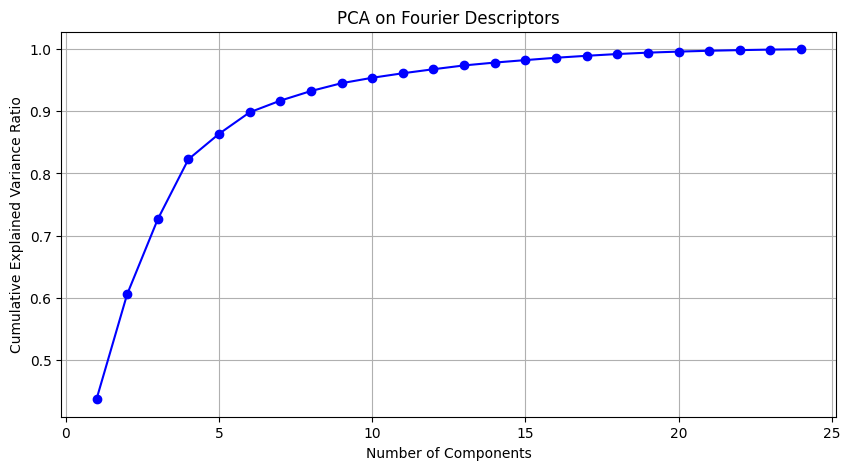

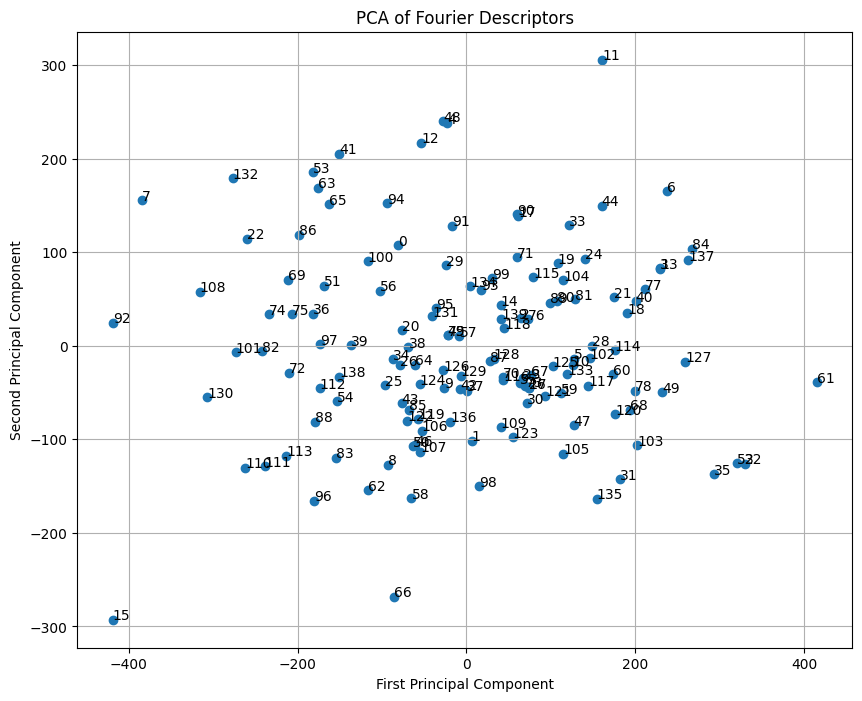

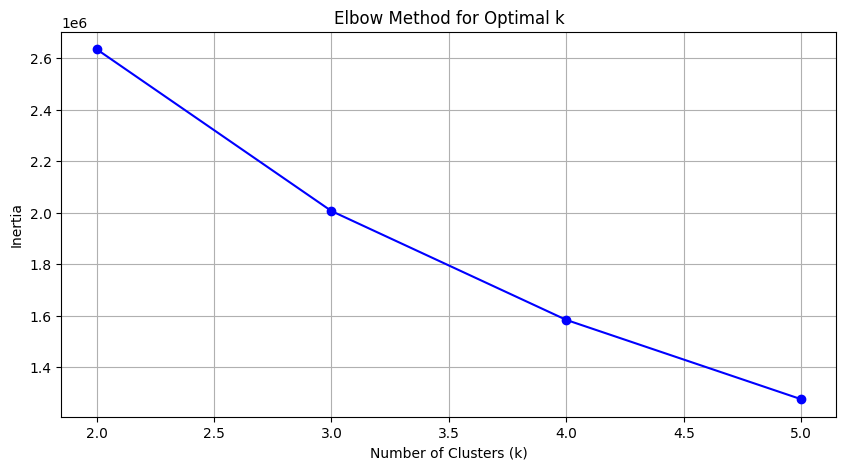

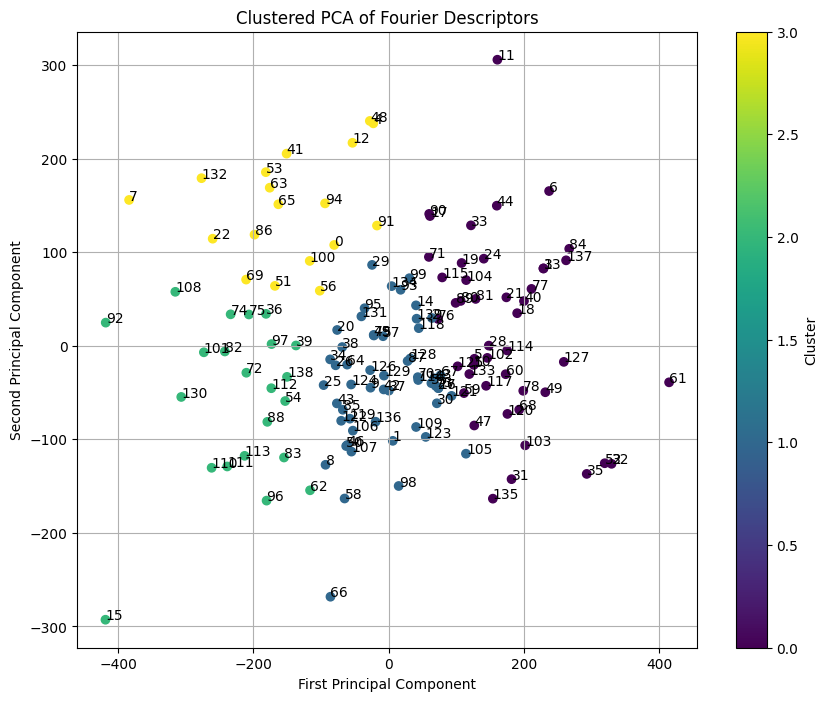

In [8]:
# Reshape the Fourier descriptors into a 2D array
fd_array = numpy.array(fourier_descriptors).reshape(len(fourier_descriptors), -1)

# Perform PCA
from sklearn.decomposition import PCA

pca = PCA()
fd_pca = pca.fit_transform(fd_array)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = numpy.cumsum(explained_variance_ratio)

# Print variance explained by components
print("Variance explained by each component:")
for i, var in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {var:.3f}")

print("\nCumulative variance explained:")
for i, cum_var in enumerate(cumulative_variance_ratio[:10]):
    print(f"First {i+1} PCs: {cum_var:.3f}")

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA on Fourier Descriptors')
plt.grid(True)
plt.show()

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(fd_pca[:, 0], fd_pca[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Fourier Descriptors')

# Add cell number labels to the points
for i, cell in enumerate(cell_names):
    plt.annotate(str(cell), (fd_pca[i, 0], fd_pca[i, 1]))

plt.grid(True)
plt.show()

# Perform K-means clustering on PCA results
from sklearn.cluster import KMeans

# Try different numbers of clusters
n_clusters_range = range(2, 6)
inertias = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(fd_pca[:, :2])  # Using first 2 PCs
    inertias.append(kmeans.inertia_)

# Plot elbow curve to help determine optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Apply K-means with chosen number of clusters (using k=3 as example)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(fd_pca[:, :2])

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(fd_pca[:, 0], fd_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustered PCA of Fourier Descriptors')

# Add cell number labels to the points
for i, cell in enumerate(cell_names):
    plt.annotate(str(cell), (fd_pca[i, 0], fd_pca[i, 1]))

plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()




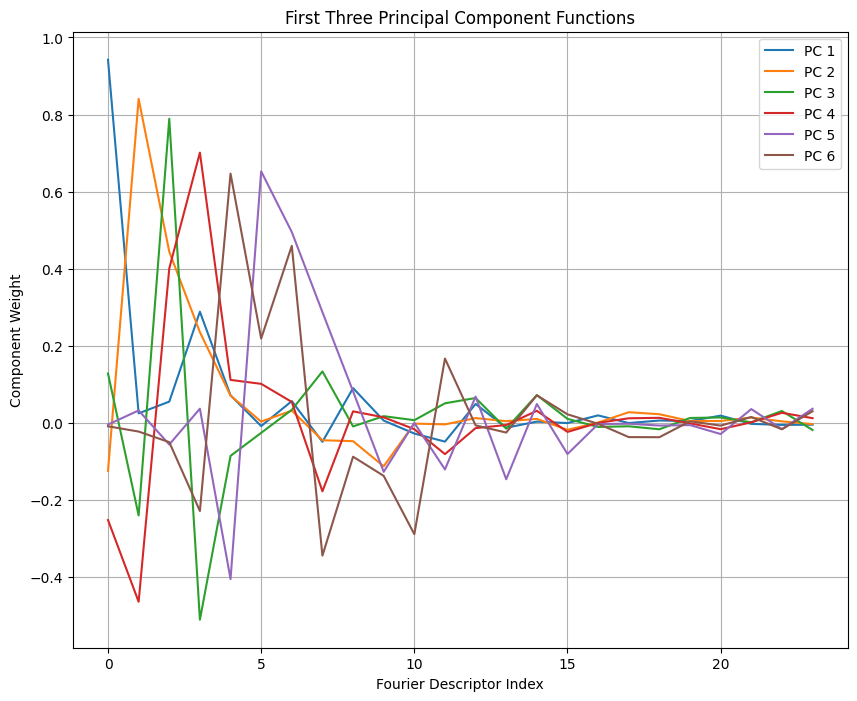

In [9]:
# Plot the first few principal component functions
plt.figure(figsize=(10, 8))

# Get the components from the PCA object
components = pca.components_

# Plot first 3 principal components
for i in range(6):
    plt.plot(components[i], label=f'PC {i+1}')

plt.xlabel('Fourier Descriptor Index')
plt.ylabel('Component Weight')
plt.title('First Three Principal Component Functions')
plt.legend()
plt.grid(True)
plt.show()


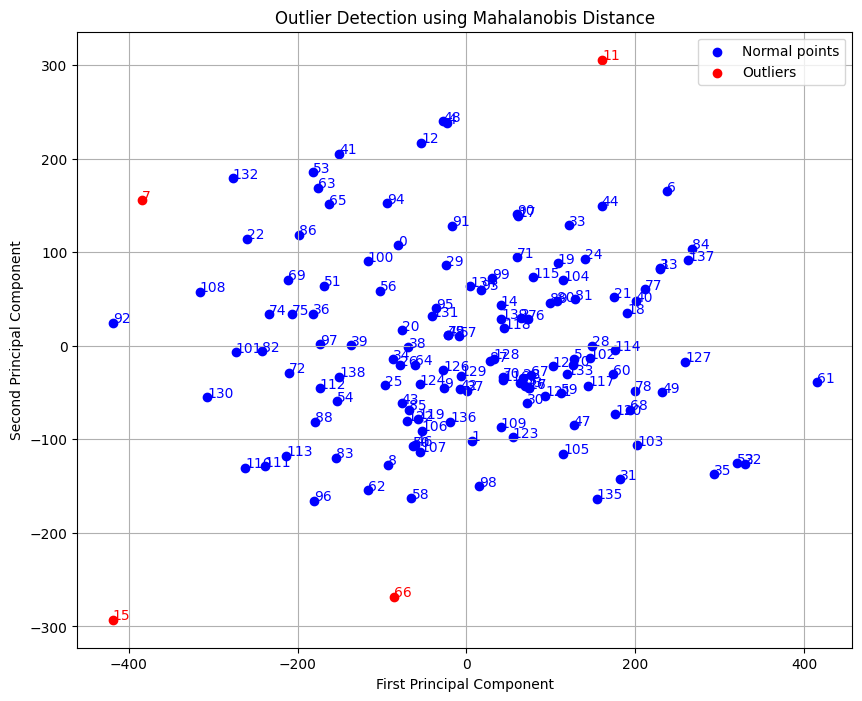


Outlier cells:
[66, 11, 7, 15]


In [10]:
# Calculate Mahalanobis distances for outlier detection
from scipy.stats import chi2

# Calculate mean and covariance of the PCA data
mean = numpy.mean(fd_pca[:, :2], axis=0)
covariance = numpy.cov(fd_pca[:, :2].T)

# Calculate Mahalanobis distances
def mahalanobis(x, mean, cov):
    diff = x - mean
    inv_covmat = numpy.linalg.inv(cov)
    left = numpy.dot(diff, inv_covmat)
    mahal = numpy.dot(left, diff.T)
    return numpy.sqrt(mahal)

mahalanobis_dist = numpy.array([mahalanobis(x, mean, covariance) for x in fd_pca[:, :2]])

# Define threshold for outliers (e.g., 97.5th percentile of chi-square distribution)a
threshold = numpy.sqrt(chi2.ppf(0.975, df=2))  # df=2 because we're using 2 PCA components

# Identify outliers
outliers = mahalanobis_dist > threshold

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(fd_pca[~outliers, 0], fd_pca[~outliers, 1], c='blue', label='Normal points')
plt.scatter(fd_pca[outliers, 0], fd_pca[outliers, 1], c='red', label='Outliers')

# Add cell number labels
for i, cell in enumerate(cell_names):
    color = 'red' if outliers[i] else 'blue'
    plt.annotate(str(cell), (fd_pca[i, 0], fd_pca[i, 1]), color=color)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Outlier Detection using Mahalanobis Distance')
plt.legend()
plt.grid(True)
plt.show()

# Print outlier information
print("\nOutlier cells:")
outlier_cells = [cell for i, cell in enumerate(cell_names) if outliers[i]]
print(outlier_cells)


In [11]:
# Hierarchical clustering on PCA scores
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler

# Choose number of PCs to retain (e.g., cover 95% variance)
variance_threshold = 0.95
num_pcs = int(numpy.searchsorted(numpy.cumsum(pca.explained_variance_ratio_), variance_threshold) + 1)

# Use the selected PCs' scores
scores = fd_pca[:, :num_pcs]

# Standardize scores before clustering (good practice for Ward)
scaler = StandardScaler()
scores_std = scaler.fit_transform(scores)

# Perform hierarchical clustering (Ward linkage on Euclidean distances)
linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="ward")
# Z = linkage(scores_std, method='ward', n_clusters=4)

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, no_labels=True, color_threshold=0)
plt.title(f'Hierarchical Clustering Dendrogram (Ward) with {k} clusters')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Cut the dendrogram to obtain cluster labels
k = 4  # adjust as needed
labels_hc = fcluster(Z, t=k, criterion='maxclust')

# Scatter of first two PCs colored by hierarchical clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(fd_pca[:, 0], fd_pca[:, 1], c=labels_hc, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA scores colored by hierarchical clusters (Ward)')

# Annotate with cell ids
for i, cell in enumerate(cell_names):
    plt.annotate(str(cell), (fd_pca[i, 0], fd_pca[i, 1]), fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Optional: collect results
hc_results = pandas.DataFrame({
    'cell': cell_names,
    'cluster_ward_k4': labels_hc
})

hc_results.head()


NameError: name 'Z' is not defined

<Figure size 1200x600 with 0 Axes>